# Demo of RtDeep

We define a simple network using RtDeep with microcircuits.

Task: mapping a 1-D signal in time onto another 1-D signal.

The model uses real time dynamics with Euler integration, LE, dendritic error propagation and a phased implementation of DTP-DRL.

## Definitions

In [1]:
%matplotlib widget

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=18,family='serif')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from microcircuit import *
import sys
import pandas as pd


#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport microcircuit

## Test self-predicting dynamics (no target)

### Setup

In [2]:
# simulation settings

dt = 0.01 # in ms
tauxi = None
Tpres = 100 * dt
Ttot = 100 * Tpres # total simulation time

In [11]:
np.random.seed(1234)

# Init model: weights, voltages

layers = [1, 1, 1]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [0.0] * (len(layers) - 1)
eta_IP = [40.0] * (len(layers) - 1)
eta_PI = [50.0] * (len(layers) - 1)

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i])))

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))

In [12]:
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(int(Tpres / dt), layers[0]))
r0_random = np.repeat(r0_random, int(Ttot / Tpres), axis=0)

In [26]:
mc1 = model(dt, tauxi, Tpres, 'FA', logistic, d_logistic, layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

### Simulation

In [27]:
u_time_series = []
uIbreve_time_series = []
uPbreve_time_series = []
rIbreve_time_series = []
rPbreve_time_series = []
vapi_time_series = []

WPP_time_series = []
BPP_time_series = []
WIP_time_series = []
BPI_time_series = []

for i in range(len(r0_random)):
    mc1.evolve_system(r0=r0_random[i])
    
    uIbreve_time_series.append(copy.deepcopy(mc1.uI_breve))
    uPbreve_time_series.append(copy.deepcopy(mc1.uP_breve))
    rIbreve_time_series.append(copy.deepcopy(mc1.rI_breve))
    rPbreve_time_series.append(copy.deepcopy(mc1.rP_breve))
    u_time_series.append(copy.deepcopy(mc1.get_voltages()))

    vapi_time_series.append(copy.deepcopy(mc1.vapi))
    WPP, WIP, BPP, BPI = mc1.get_weights()
    WPP_time_series.append(copy.deepcopy(WPP))
    BPP_time_series.append(copy.deepcopy(BPP))
    WIP_time_series.append(copy.deepcopy(WIP))
    BPI_time_series.append(copy.deepcopy(BPI))
        
uP_time_series = [u[0] for u in u_time_series]
uI_time_series = [u[1] for u in u_time_series]

### Evaluation

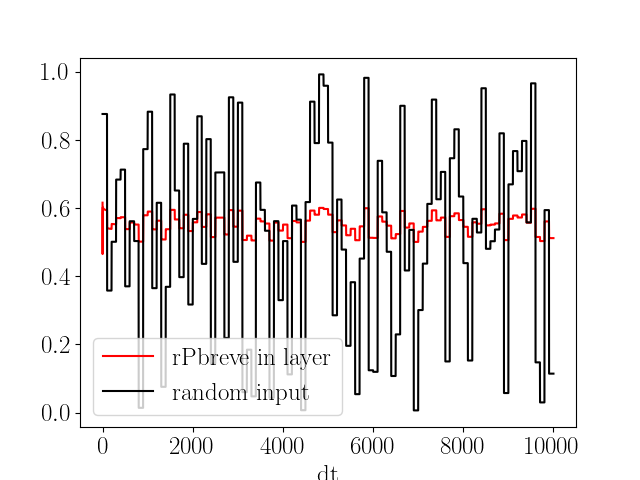

In [28]:
# Check that rP_breve correctly follows time scales of input

fig = plt.figure()
plt.plot(np.array([rPbreve[0] for rPbreve in rPbreve_time_series]).ravel(), label="rPbreve in layer" , c='r')
plt.plot(r0_random, label="random input", c='k')
plt.legend()
plt.xlabel('dt')
plt.show()

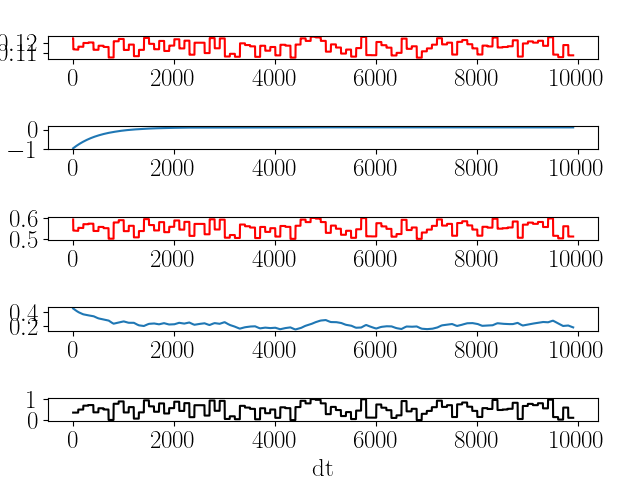

In [33]:
# in order to make this plot easier to read, we skip the first Tpres / dt samples

fig, ax = plt.subplots(len(uP_time_series[0]) + len(rPbreve_time_series[0]) + 1)

plt.tight_layout()

ax[len(ax)-1].plot(r0_random[int(Tpres/dt):], 'k')

for i in range(len(rPbreve_time_series[0])):
    rPbreve = np.array([rPbreve[i] for rPbreve in rPbreve_time_series[int(Tpres/dt):]])
    ax[len(ax)-2-2*i-1].plot(rPbreve, 'r')
    
for j in range(len(uP_time_series[0])):
    uP = np.array([uP[j] for uP in uP_time_series[int(Tpres/dt):]])
    ax[len(ax)-2-2*j].plot(uP)

plt.yscale('linear')

label = 'dt'
plt.xlabel(label)
# plt.legend()

plt.show()

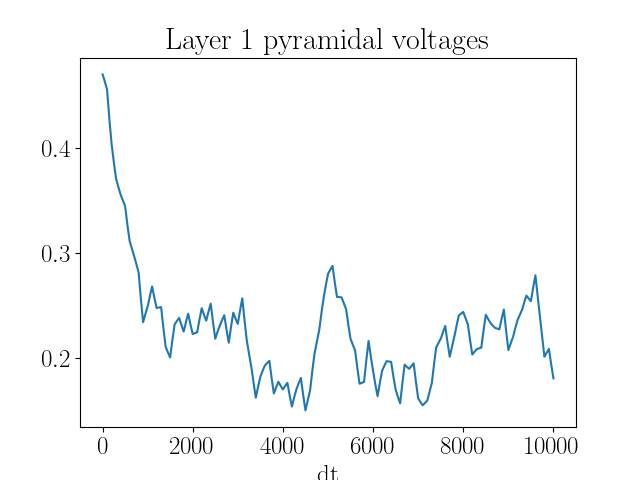

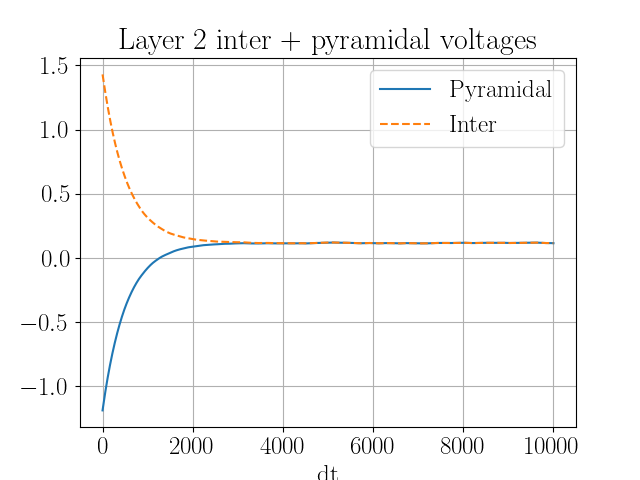

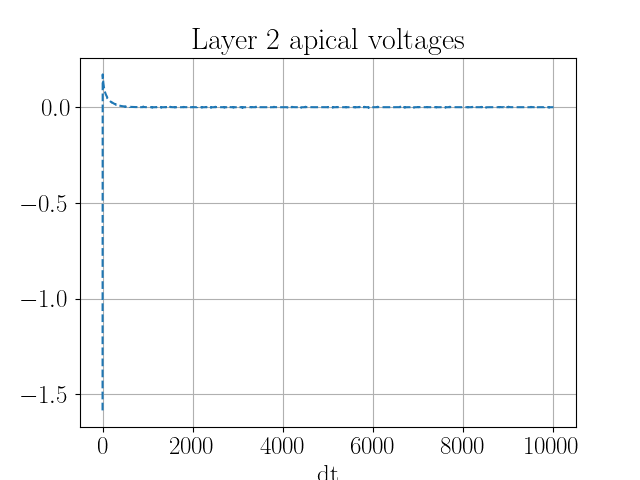

In [37]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    uP = np.array([uP[i] for uP in uP_time_series])
    ax.plot(uP)
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.title(f'Layer {i+1} pyramidal voltages')
    plt.show()

# fig, ax = plt.subplots()
uI = np.array(uI_time_series).reshape(-1, np.array(uI_time_series).shape[-1])
# ax.plot(uI, '--')
# plt.yscale('linear')
# label = '$T_{ \mathrm{pres}} $'
# plt.xlabel(label)
# plt.title(f'Layer {len(layers)-1} interneuron voltages')
# plt.show()

fig, ax = plt.subplots()
uP = np.array([uP[-1] for uP in uP_time_series])
ax.plot(uP, label='Pyramidal')
ax.plot(uI, '--', label='Inter')
plt.yscale('linear')
label = 'dt'
plt.xlabel(label)
plt.title(f'Layer {len(layers)-1} inter + pyramidal voltages')
plt.grid()
plt.legend()
plt.show()


fig, ax = plt.subplots()
vapi = np.array(vapi_time_series).reshape(-1, np.array(uI_time_series).shape[-1])
ax.plot(vapi, '--')
# plt.yscale('log')
label = 'dt'
plt.xlabel(label)
plt.grid()
plt.title(f'Layer {len(layers)-1} apical voltages')
plt.show()

Now, let's also check that BPI has converged onto -BPP and WIP onto WPP:

In [38]:
cos_BPI_BPP = []
for i in range(len(BPI_time_series[0])):
    cos_BPI_BPP.append(np.array([
        cos_sim(BPI_time_series[j][i], -BPP_time_series[j][i]) for j in range(len(BPI_time_series))
                           ]))
    
cos_WIP_WPP = []
for i in range(len(WIP_time_series[0])):
    cos_WIP_WPP.append(np.array([
        cos_sim(WIP_time_series[j][i], WPP_time_series[j][i+1]) for j in range(len(WIP_time_series))
                           ]))

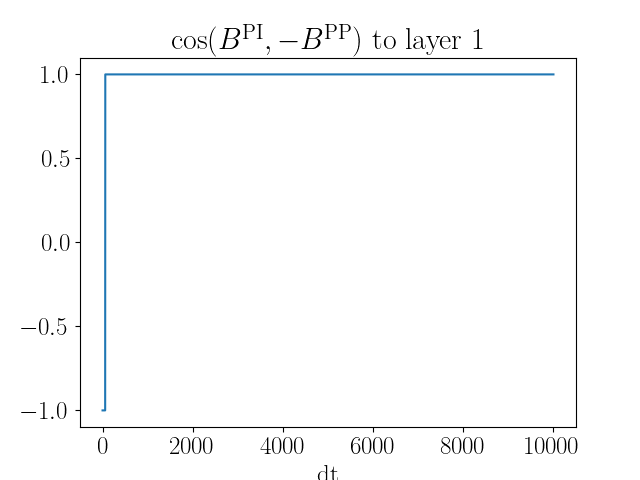

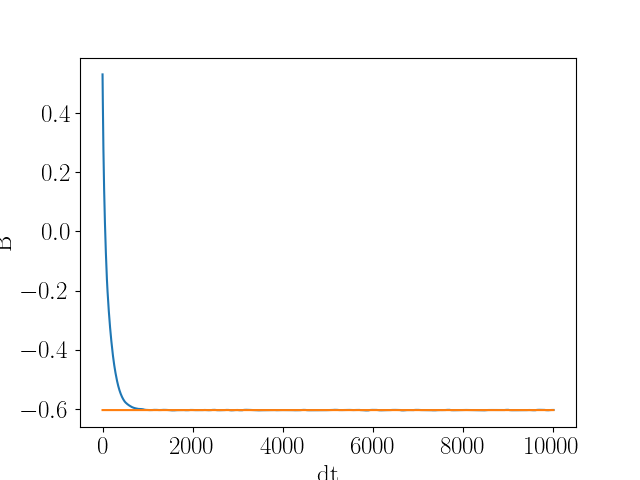

In [39]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_BPI_BPP[i])
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()
    

fig, ax = plt.subplots()
ax.plot(np.array(BPI_time_series).ravel())
ax.plot(-np.array(BPP_time_series).ravel())
plt.yscale('linear')
label = 'dt'
plt.xlabel(label)
plt.ylabel("B")
# plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
plt.show()

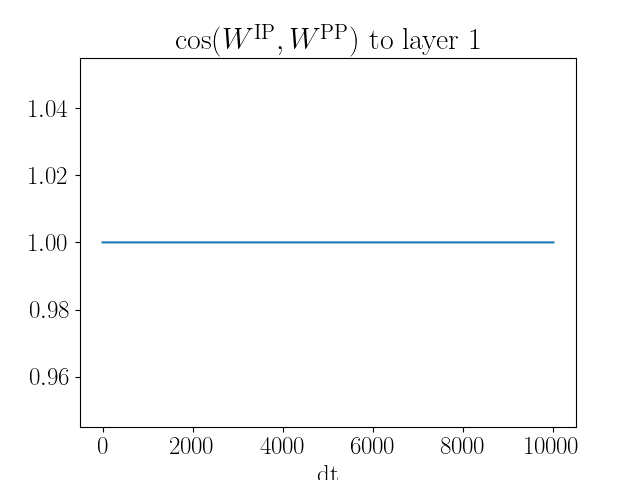

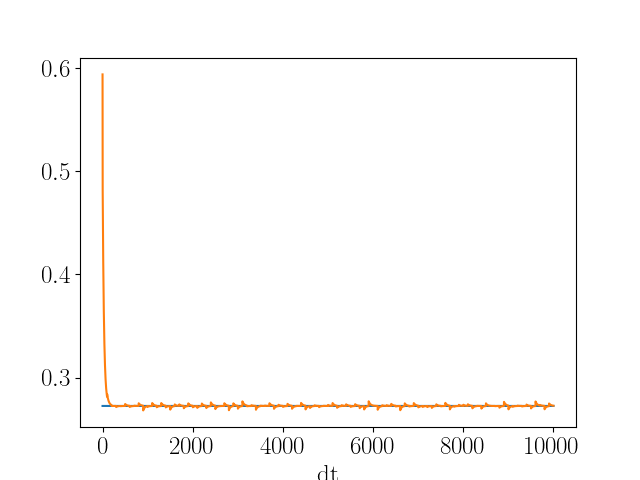

In [40]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WIP_WPP[i])
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()


fig, ax = plt.subplots()
ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
ax.plot(np.array(WIP_time_series).ravel())
plt.yscale('linear')
label = 'dt'
plt.xlabel(label)
plt.show()

## Test learning of WPP with FA

In [ ]:
mc1 = model(dt, tauxi, Tpres, 'FA', logistic, d_logistic, layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)